c:\Users\legende\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 1.8833e-04 - mae: 0.0069 - val_loss: 6.7500e-05 - val_mae: 0.0038 - learning_rate: 0.0010
Epoch 2/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 1.3374e-04 - mae: 0.0056 - val_loss: 6.1724e-05 - val_mae: 0.0040 - learning_rate: 0.0010
Epoch 3/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.1744e-04 - mae: 0.0052 - val_loss: 5.6556e-05 - val_mae: 0.0031 - learning_rate: 0.0010
Epoch 4/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.0934e-04 - mae: 0.0049 - val_loss: 6.5935e-05 - val_mae: 0.0035 - learning_rate: 0.0010
Epoch 5/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.0312e-04 - mae: 0.0047 - val_loss: 6.4898e-05 - val_mae: 0.0034 - learning_rate: 0.0010
Epoch 6/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 9.9136e-05 - mae: 0.0046 - val_loss: 6.5325e-05 - val_mae: 0.0033 - learning_rate: 0.0010
Epoch 7/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 9.2851e-05 - mae:

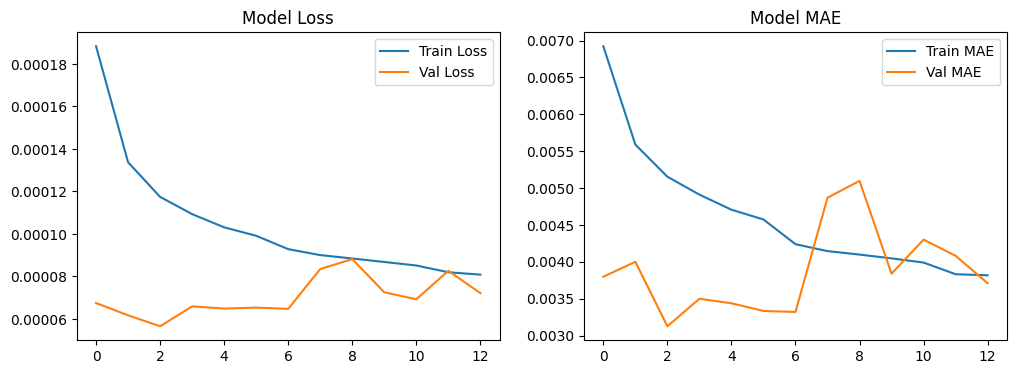

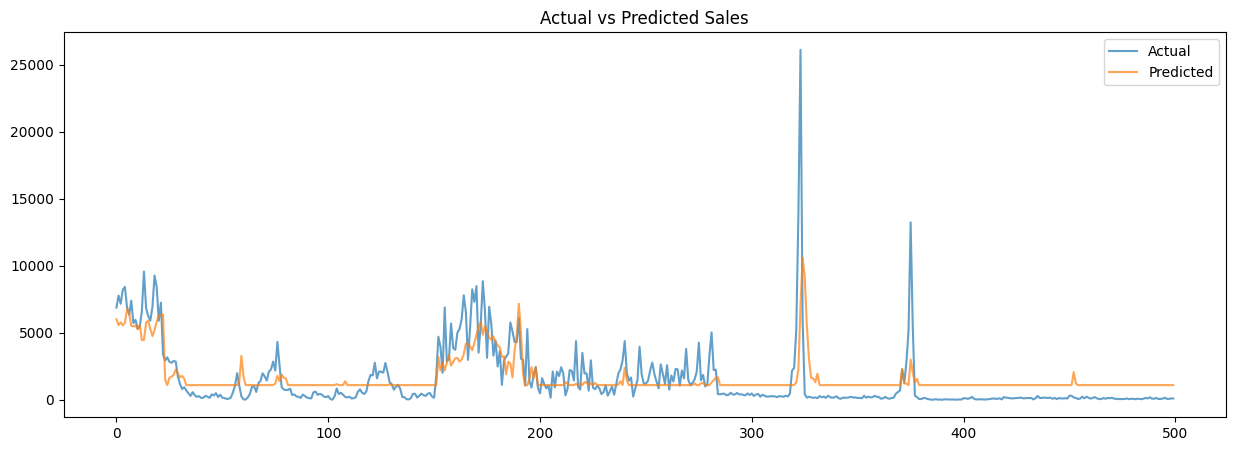

Model saved!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

NewTrain = pd.read_csv("../Data/NewTrain.csv")

feature_cols = [
    'Store', 'Dept', 'Type', 'Size',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'IsHoliday', 'year', 'month', 'week', 'day_of_year',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'roll_4', 'roll_8'
]

X = NewTrain[feature_cols].values
y = NewTrain['Weekly_Sales'].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

TIME_STEPS = 4
    
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

split_idx = int(len(X_seq) * 0.8)
X_train = X_seq[:split_idx]
X_test = X_seq[split_idx:]
y_train = y_seq[:split_idx]
y_test = y_seq[split_idx:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_actual[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

model.save('walmart_lstm_model.h5')

import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("Model saved!")